In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
import math

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual
from ipywidgets import FloatSlider

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x, start, stop):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs[start:stop], index=x.columns[start:stop]))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv("data/tracks.csv", index_col=0)
pitch_df = pd.read_csv("data/pitch_covariance.csv", index_col=0)
timbre_df = pd.read_csv("data/timbre_covariance.csv", index_col=0)

df["genres"] = df["genres"].fillna("not listed")

<IPython.core.display.Javascript object>

In [5]:
X = timbre_df.drop("id", 1)

<IPython.core.display.Javascript object>

In [6]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [7]:
# putting together hover information for plotly data later

desc_cols = [
    "artist",
    "title",
    "popularity",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "genres",
]

px_num = df[desc_cols].select_dtypes("number")
px_cat = df[desc_cols].select_dtypes("O")

minmax_scaler = MinMaxScaler()
scaled_num = pd.DataFrame(minmax_scaler.fit_transform(px_num), columns=px_num.columns)
px_df = pd.concat([scaled_num, px_cat], 1)
px_df = px_df.round(1)

<IPython.core.display.Javascript object>

In [8]:
# first set of decent params
#     n_neighbors=6,
#     min_dist=0.1,
#     metric="cosine",
# dbscan
# eps=0.2, min_samples=40

# tighter clusters
#n_neighbors=12, min_dist=0.001 
#eps=0.2, min_samples=40
# clusters even tighter
#eps=0.17, min_samples=45
# pretty good at clustering out the more 'exotic' soounding stuff
#eps=0.13, min_samples=30



<IPython.core.display.Javascript object>

In [9]:
umap = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])

<IPython.core.display.Javascript object>

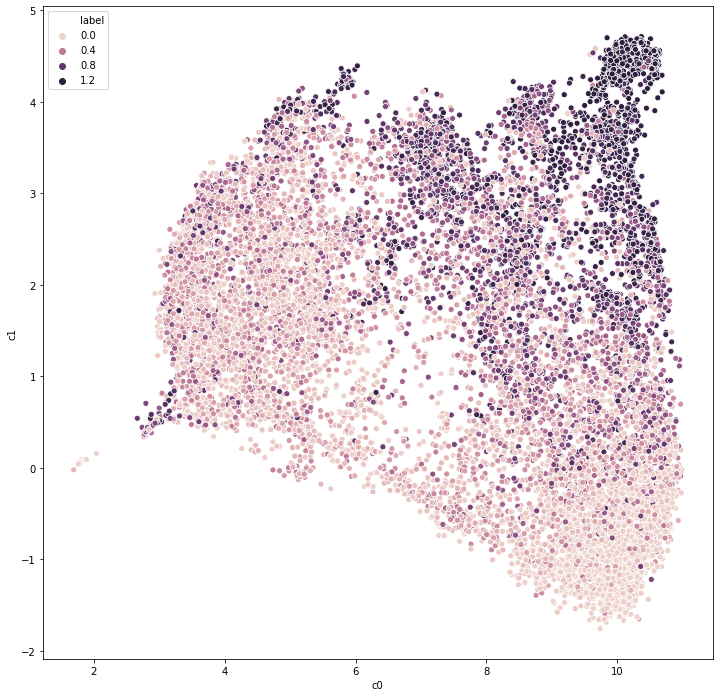

<IPython.core.display.Javascript object>

In [10]:
umap_df["label"] = df["acousticness"]
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", hue="label", data=umap_df)

In [11]:
px_df["x1"] = umap_df["c0"]
px_df["x2"] = umap_df["c1"]

<IPython.core.display.Javascript object>

In [12]:
X = umap_df[["c0", "c1"]]

clst = DBSCAN(eps=0.13, min_samples=30)
clst.fit(X)

DBSCAN(algorithm='auto', eps=0.13, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [13]:
px_df["clst_label"] = clst.labels_
px_df["clst_label"].value_counts()

-1     4249
 3     2955
 0     1877
 1      542
 4      413
 6      366
 5      331
 14     304
 12     243
 16     233
 25     215
 13     205
 2      140
 9      126
 19     109
 23     104
 10      69
 11      65
 7       65
 17      63
 21      57
 22      57
 24      53
 18      50
 15      47
 20      46
 8       42
 27      30
 26      15
Name: clst_label, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
px_df["clst_label"].nunique()

29

<IPython.core.display.Javascript object>

In [15]:
# Remove DBSCAN's outlier cluster
plot_df = px_df[px_df["clst_label"] != -1].copy()

# Make cluster label a string so plotly colors like categorical rather than continuous
plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

In [16]:
x_range = [math.floor(plot_df["x1"].min()), math.ceil(plot_df["x1"].max())]
y_range = [math.floor(plot_df["x2"].min()), math.ceil(plot_df["x2"].max())]

descriptors = px_num.columns

<IPython.core.display.Javascript object>

In [17]:


@interact(
    filter_col = descriptors,
    min_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=0,continuous_update=False),
    max_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=1,continuous_update=False),
    
)
def song_plot(filter_col, min_val=0.0, max_val=1.0):
    int_plot_df = plot_df.copy()
    int_plot_df = int_plot_df[int_plot_df[filter_col].between(min_val, max_val)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


interactive(children=(Dropdown(description='filter_col', options=('popularity', 'danceability', 'energy', 'lou…

<IPython.core.display.Javascript object>

In [18]:
@interact_manual(
    search_genre=False,
    genre='search'
)
def song_plot( genre,search_genre):
    
    int_plot_df = plot_df.copy()
    if search_genre==True:
        int_plot_df = int_plot_df[int_plot_df["genres"].str.contains(genre)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


interactive(children=(Text(value='search', description='genre'), Checkbox(value=False, description='search_gen…

<IPython.core.display.Javascript object>

In [19]:
art_df = pd.read_csv("data/artist_info.csv", index_col=0)

<IPython.core.display.Javascript object>

In [20]:
def get_keyword_counts(data):
    micro_genre_count = {}
    word_count = {}
    for x in data["genres"]:
        m_genres = x.split(", ")
        for m in m_genres:
            if m not in micro_genre_count:
                micro_genre_count[m] = 1
            else:
                micro_genre_count[m] += 1
            words = m.split(" ")
            for word in words:
                if word not in word_count:
                    word_count[word] = 1
                else:
                    word_count[word] += 1
    try:
        del micro_genre_count[""]
        del word_count[""]
    except:
        pass
    return micro_genre_count, word_count

<IPython.core.display.Javascript object>

In [21]:
micro_genre_count, word_count = get_keyword_counts(df)

<IPython.core.display.Javascript object>

In [22]:
m_genre_series = pd.Series(micro_genre_count)
word_count_series = pd.Series(word_count)

<IPython.core.display.Javascript object>

In [23]:
whole_df_m_genre_rep = m_genre_series / df.shape[0]
whole_df_w_count_rep = word_count_series / df.shape[0]

<IPython.core.display.Javascript object>

In [24]:
clust_genre_dict = {}
clust_word_dict = {}

for cl in px_df["clst_label"].unique():
    cluster_sub_df = px_df[px_df["clst_label"] == cl]
    micro_genre_count, word_count = get_keyword_counts(cluster_sub_df)

    m_genre_series = pd.Series(micro_genre_count)
    word_series = pd.Series(word_count)

    m_genre_rep = m_genre_series / cluster_sub_df.shape[0]
    w_count_rep = word_series / cluster_sub_df.shape[0]

    clust_genre_dict["cluster_" + str(cl)] = m_genre_rep
    clust_word_dict["cluster_" + str(cl)] = w_count_rep

<IPython.core.display.Javascript object>

In [25]:
cluster_genre_df = pd.DataFrame(clust_genre_dict)
cluster_keyword_df = pd.DataFrame(clust_word_dict)

<IPython.core.display.Javascript object>

In [26]:
for col in cluster_genre_df.columns:
    top_7_g = cluster_genre_df[col].sort_values(ascending=False)[0:7]
    top_7_comp = whole_df_m_genre_rep[top_7_g.index]
    print("Micro Genre Comparison")
    display(
        pd.DataFrame(
            [top_7_g, top_7_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    top_12_w = cluster_keyword_df[col].sort_values(ascending=False)[0:12]
    top_12_comp = whole_df_w_count_rep[top_12_w.index]
    print("Keyword Comparison")
    display(
        pd.DataFrame(
            [top_12_w, top_12_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )

Micro Genre Comparison


,cluster_0,df
rap,0.210975,0.045903
pop,0.178476,0.104659
pop rap,0.163559,0.043531
hip hop,0.134790,0.034121
trap,0.130527,0.024176
dance pop,0.122003,0.076658
melodic rap,0.092168,0.016755


Keyword Comparison


,cluster_0,df
pop,0.995738,0.748068
rap,0.812999,0.195088
hip,0.775706,0.191646
hop,0.737880,0.177645
trap,0.295685,0.061816
r&b,0.269046,0.089205
dance,0.136921,0.120802
indie,0.124134,0.181317
reggae,0.114012,0.055160
dancehall,0.109217,0.032438


Micro Genre Comparison


,cluster_1,df
latin,0.265683,0.032974
reggaeton,0.238007,0.016296
pop,0.171587,0.104659
dance pop,0.154982,0.076658
tropical,0.145756,0.018208
latin pop,0.118081,0.022263
reggaeton flow,0.107011,0.006120


Keyword Comparison


,cluster_1,df
pop,1.256458,0.748068
latin,0.531365,0.112922
reggaeton,0.453875,0.030755
hip,0.269373,0.191646
hop,0.260148,0.177645
tropical,0.190037,0.043761
dance,0.186347,0.120802
rap,0.180812,0.195088
reggae,0.166052,0.055160
trap,0.166052,0.061816


Micro Genre Comparison


,cluster_-1,df
pop,0.125677,0.104659
dance pop,0.092022,0.076658
not listed,0.072017,0.075128
rock,0.061897,0.075281
soul,0.053424,0.036340
funk,0.051542,0.034504
post-teen pop,0.042128,0.036570


Keyword Comparison


,cluster_-1,df
pop,0.806778,0.748068
rock,0.530478,0.592304
indie,0.196281,0.181317
soul,0.177454,0.131283
jazz,0.170393,0.154005
hip,0.136973,0.191646
dance,0.135326,0.120802
country,0.126853,0.117359
folk,0.125677,0.098921
house,0.125441,0.085839


Micro Genre Comparison


,cluster_6,df
modern bollywood,0.207650,0.026394
filmi,0.196721,0.022875
desi pop,0.193989,0.031138
sufi,0.188525,0.017290
classic bollywood,0.112022,0.005508
dance pop,0.090164,0.076658
not listed,0.081967,0.075128


Keyword Comparison


,cluster_6,df
pop,0.827869,0.748068
rock,0.497268,0.592304
bollywood,0.319672,0.031903
modern,0.248634,0.119654
soul,0.248634,0.131283
classic,0.248634,0.071303
desi,0.196721,0.036952
filmi,0.196721,0.022875
country,0.193989,0.117359
sufi,0.188525,0.017290


Micro Genre Comparison


,cluster_2,df
soundtrack,0.221429,0.016449
not listed,0.171429,0.075128
video game music,0.135714,0.009410
scorecore,0.128571,0.010405
compositional ambient,0.114286,0.009257
background music,0.114286,0.004743
chill out,0.100000,0.006579


Keyword Comparison


,cluster_2,df
soundtrack,0.364286,0.026930
music,0.264286,0.026012
rock,0.228571,0.592304
ambient,0.185714,0.013235
listed,0.171429,0.075128
classical,0.171429,0.100604
not,0.171429,0.075128
game,0.135714,0.010252
video,0.135714,0.009410
scorecore,0.128571,0.010405


Micro Genre Comparison


,cluster_4,df
pop,0.191283,0.104659
indie folk,0.179177,0.030220
new americana,0.101695,0.016755
stomp and holler,0.087167,0.021115
not listed,0.079903,0.075128
neo mellow,0.077482,0.020656
dance pop,0.072639,0.076658


Keyword Comparison


,cluster_4,df
pop,1.096852,0.748068
indie,0.598063,0.181317
rock,0.481840,0.592304
folk,0.355932,0.098921
alternative,0.188862,0.138704
americana,0.167070,0.030679
r&b,0.167070,0.089205
singer-songwriter,0.154964,0.024711
hop,0.147700,0.177645
new,0.145278,0.095402


Micro Genre Comparison


,cluster_3,df
rock,0.202707,0.075281
alternative rock,0.094078,0.032438
pop rock,0.086294,0.040395
alternative metal,0.082910,0.024252
modern rock,0.077496,0.035422
permanent wave,0.069036,0.026088
dance rock,0.068697,0.024252


Keyword Comparison


,cluster_3,df
rock,1.398985,0.592304
pop,0.664975,0.748068
metal,0.397293,0.107796
alternative,0.286294,0.138704
punk,0.277157,0.082779
indie,0.212521,0.181317
country,0.206091,0.117359
new,0.163790,0.095402
wave,0.161083,0.060898
modern,0.153299,0.119654


Micro Genre Comparison


,cluster_15,df
afropop,0.234043,0.012776
nigerian pop,0.234043,0.011705
reggae,0.148936,0.011093
afro dancehall,0.148936,0.007268
dancehall,0.106383,0.019279
pop,0.106383,0.104659
rock steady,0.106383,0.004820


Keyword Comparison


,cluster_15,df
pop,0.617021,0.748068
dancehall,0.340426,0.032438
nigerian,0.319149,0.017061
reggae,0.255319,0.055160
rock,0.255319,0.592304
soul,0.234043,0.131283
afropop,0.234043,0.012776
hip,0.170213,0.191646
afro,0.148936,0.014383
hop,0.148936,0.177645


Micro Genre Comparison


,cluster_10,df
arab pop,0.246377,0.007191
not listed,0.144928,0.075128
shaabi,0.144928,0.004820
dabke,0.130435,0.003596
pop,0.115942,0.104659
dance pop,0.086957,0.076658
jordanian pop,0.086957,0.001836


Keyword Comparison


,cluster_10,df
pop,1.347826,0.748068
arab,0.289855,0.016602
listed,0.144928,0.075128
new,0.144928,0.095402
not,0.144928,0.075128
dance,0.144928,0.120802
shaabi,0.144928,0.004820
rock,0.130435,0.592304
dabke,0.130435,0.003596
r&b,0.101449,0.089205


Micro Genre Comparison


,cluster_13,df
indie folk,0.258537,0.030220
stomp and holler,0.160976,0.021115
new americana,0.146341,0.016755
rock,0.136585,0.075281
modern rock,0.136585,0.035422
indie rock,0.131707,0.022263
indie pop,0.107317,0.023564


Keyword Comparison


,cluster_13,df
rock,1.058537,0.592304
pop,0.780488,0.748068
indie,0.775610,0.181317
folk,0.502439,0.098921
country,0.341463,0.117359
new,0.253659,0.095402
alternative,0.243902,0.138704
americana,0.243902,0.030679
modern,0.209756,0.119654
stomp,0.180488,0.022340


Micro Genre Comparison


,cluster_5,df
not listed,0.274924,0.075128
chill out,0.099698,0.006579
pop,0.087613,0.104659
dance pop,0.057402,0.076658
tropical house,0.045317,0.024329
edm,0.036254,0.021880
afropop,0.036254,0.012776


Keyword Comparison


,cluster_5,df
pop,0.389728,0.748068
house,0.299094,0.085839
listed,0.274924,0.075128
not,0.274924,0.075128
chill,0.129909,0.012623
indie,0.126888,0.181317
r&b,0.117825,0.089205
rock,0.105740,0.592304
out,0.099698,0.006579
rap,0.093656,0.195088


Micro Genre Comparison


,cluster_11,df
dance pop,0.184615,0.076658
pop,0.184615,0.104659
tropical house,0.138462,0.024329
edm,0.138462,0.021880
electro house,0.107692,0.014306
latin,0.092308,0.032974
post-teen pop,0.092308,0.036570


Keyword Comparison


,cluster_11,df
pop,1.092308,0.748068
house,0.553846,0.085839
rock,0.323077,0.592304
dance,0.246154,0.120802
latin,0.246154,0.112922
tropical,0.230769,0.043761
indie,0.200000,0.181317
edm,0.200000,0.034427
electro,0.184615,0.023181
jazz,0.169231,0.154005


Micro Genre Comparison


,cluster_27,df
dance pop,0.233333,0.076658
pop,0.233333,0.104659
k-pop,0.200000,0.019432
desi pop,0.200000,0.031138
house,0.166667,0.005967
tropical house,0.166667,0.024329
modern bollywood,0.133333,0.026394


Keyword Comparison


,cluster_27,df
pop,1.100000,0.748068
house,0.500000,0.085839
dance,0.400000,0.120802
desi,0.300000,0.036952
k-pop,0.300000,0.029990
jazz,0.233333,0.154005
uk,0.200000,0.042231
r&b,0.166667,0.089205
tropical,0.166667,0.043761
soul,0.166667,0.131283


Micro Genre Comparison


,cluster_14,df
classical,0.440789,0.026318
classical performance,0.309211,0.015378
soundtrack,0.171053,0.016449
orchestral performance,0.141447,0.005585
classical era,0.131579,0.006656
orchestra,0.121711,0.006426
post-romantic era,0.108553,0.005202


Keyword Comparison


,cluster_14,df
classical,1.411184,0.100604
performance,0.486842,0.023564
orchestra,0.378289,0.018438
era,0.361842,0.019585
soundtrack,0.282895,0.026930
piano,0.161184,0.042154
early,0.157895,0.014383
german,0.151316,0.020274
music,0.148026,0.026012
modern,0.144737,0.119654


Micro Genre Comparison


,cluster_8,df
country,0.119048,0.018973
soul,0.095238,0.036340
country rock,0.095238,0.014919
piano rock,0.095238,0.003749
rock,0.095238,0.075281
new wave pop,0.095238,0.016143
brill building pop,0.095238,0.012011


Keyword Comparison


,cluster_8,df
rock,0.880952,0.592304
pop,0.857143,0.748068
country,0.404762,0.117359
soul,0.285714,0.131283
wave,0.190476,0.060898
metal,0.166667,0.107796
classic,0.166667,0.071303
new,0.119048,0.095402
christian,0.119048,0.016678
alternative,0.119048,0.138704


Micro Genre Comparison


,cluster_17,df
pop,0.111111,0.104659
dance pop,0.095238,0.076658
rock-and-roll,0.095238,0.009640
country,0.095238,0.018973
rockabilly,0.095238,0.007651
folk rock,0.079365,0.022569
urban contemporary,0.063492,0.033433


Keyword Comparison


,cluster_17,df
pop,0.825397,0.748068
rock,0.666667,0.592304
country,0.285714,0.117359
latin,0.206349,0.112922
hip,0.174603,0.191646
rap,0.158730,0.195088
hop,0.158730,0.177645
folk,0.142857,0.098921
metal,0.142857,0.107796
dance,0.142857,0.120802


Micro Genre Comparison


,cluster_12,df
funk,0.242798,0.034504
soul,0.185185,0.036340
motown,0.156379,0.027618
quiet storm,0.152263,0.027848
urban contemporary,0.106996,0.033433
dance pop,0.102881,0.076658
disco,0.098765,0.014842


Keyword Comparison


,cluster_12,df
rock,0.703704,0.592304
pop,0.584362,0.748068
funk,0.489712,0.075740
soul,0.403292,0.131283
jazz,0.209877,0.154005
new,0.193416,0.095402
house,0.176955,0.085839
dance,0.172840,0.120802
motown,0.156379,0.028154
african,0.152263,0.013312


Micro Genre Comparison


,cluster_7,df
pop,0.215385,0.104659
indie folk,0.153846,0.030220
new americana,0.123077,0.016755
folk,0.123077,0.014153
stomp and holler,0.107692,0.021115
folk rock,0.076923,0.022569
lilith,0.076923,0.005432


Keyword Comparison


,cluster_7,df
pop,0.938462,0.748068
rock,0.723077,0.592304
folk,0.523077,0.098921
indie,0.446154,0.181317
country,0.338462,0.117359
soul,0.261538,0.131283
new,0.215385,0.095402
americana,0.200000,0.030679
and,0.123077,0.024252
stomp,0.123077,0.022340


Micro Genre Comparison


,cluster_9,df
tropical,0.277778,0.018208
salsa,0.253968,0.004590
latin,0.222222,0.032974
latin jazz,0.134921,0.007268
modern salsa,0.126984,0.001913
salsa peruana,0.119048,0.001377
latin pop,0.087302,0.022263


Keyword Comparison


,cluster_9,df
salsa,0.746032,0.012088
pop,0.555556,0.748068
latin,0.500000,0.112922
jazz,0.396825,0.154005
tropical,0.277778,0.043761
rock,0.230159,0.592304
modern,0.222222,0.119654
soul,0.126984,0.131283
peruana,0.119048,0.001377
colombiana,0.111111,0.001530


Micro Genre Comparison


,cluster_26,df
pop,0.266667,0.104659
k-pop,0.133333,0.019432
latin pop,0.133333,0.022263
album rock,0.133333,0.022263
neo mellow,0.133333,0.020656
latin,0.133333,0.032974
hard rock,0.133333,0.015684


Keyword Comparison


,cluster_26,df
pop,1.266667,0.748068
rock,1.133333,0.592304
punk,0.333333,0.082779
latin,0.266667,0.112922
k-pop,0.266667,0.029990
hop,0.200000,0.177645
hip,0.200000,0.191646
neo,0.200000,0.039706
soul,0.200000,0.131283
dance,0.200000,0.120802


Micro Genre Comparison


,cluster_23,df
"""children's story""",0.336538,0.002831
nursery,0.182692,0.001683
not listed,0.153846,0.075128
"""children's music""",0.105769,0.004055
pop,0.048077,0.104659
neo soul,0.048077,0.017749
urban contemporary,0.048077,0.033433


Keyword Comparison


,cluster_23,df
"""children's",0.461538,0.008722
"story""",0.336538,0.002831
nursery,0.182692,0.001683
not,0.153846,0.075128
listed,0.153846,0.075128
pop,0.125000,0.748068
"music""",0.125000,0.005355
soul,0.115385,0.131283
neo,0.086538,0.039706
reading,0.048077,0.000536


Micro Genre Comparison


,cluster_25,df
contemporary post-bop,0.530233,0.014077
jazz,0.506977,0.014383
cool jazz,0.497674,0.014077
bebop,0.479070,0.013465
hard bop,0.409302,0.011170
soul jazz,0.353488,0.011017
jazz fusion,0.348837,0.010634


Keyword Comparison


,cluster_25,df
jazz,3.990698,0.154005
contemporary,0.790698,0.089817
post-bop,0.530233,0.014077
cool,0.497674,0.014077
bebop,0.479070,0.013465
hard,0.409302,0.027542
bop,0.409302,0.011170
fusion,0.395349,0.023487
soul,0.372093,0.131283
vocal,0.241860,0.010940


Micro Genre Comparison


,cluster_20,df
motown,0.195652,0.027618
brill building pop,0.173913,0.012011
soul,0.173913,0.036340
rock,0.152174,0.075281
folk rock,0.130435,0.022569
adult standards,0.130435,0.018132
country,0.108696,0.018973


Keyword Comparison


,cluster_20,df
rock,1.000000,0.592304
pop,0.913043,0.748068
country,0.434783,0.117359
soul,0.304348,0.131283
classic,0.282609,0.071303
blues,0.239130,0.034427
motown,0.195652,0.028154
metal,0.195652,0.107796
brill,0.173913,0.012011
building,0.173913,0.012011


Micro Genre Comparison


,cluster_18,df
desi pop,0.140000,0.031138
soul,0.140000,0.036340
motown,0.120000,0.027618
classic soul,0.120000,0.017520
rock-and-roll,0.100000,0.009640
brill building pop,0.100000,0.012011
filmi,0.100000,0.022875


Keyword Comparison


,cluster_18,df
pop,0.520000,0.748068
rock,0.360000,0.592304
soul,0.340000,0.131283
country,0.280000,0.117359
classic,0.240000,0.071303
bollywood,0.160000,0.031903
modern,0.140000,0.119654
desi,0.140000,0.036952
alternative,0.140000,0.138704
motown,0.120000,0.028154


Micro Genre Comparison


,cluster_16,df
classical,0.429185,0.026318
classical piano,0.330472,0.008951
classical performance,0.184549,0.015378
not listed,0.133047,0.075128
early music,0.111588,0.005126
baroque,0.107296,0.004514
german baroque,0.094421,0.003749


Keyword Comparison


,cluster_16,df
classical,1.858369,0.100604
piano,0.987124,0.042154
era,0.343348,0.019585
early,0.266094,0.014383
performance,0.240343,0.023564
baroque,0.214592,0.014766
jazz,0.197425,0.154005
german,0.193133,0.020274
romantic,0.163090,0.017749
listed,0.133047,0.075128


Micro Genre Comparison


,cluster_19,df
background piano,0.348624,0.003902
not listed,0.266055,0.075128
calming instrumental,0.137615,0.004896
piano cover,0.091743,0.001989
focus,0.082569,0.003596
neo-classical,0.082569,0.003443
compositional ambient,0.073394,0.009257


Keyword Comparison


,cluster_19,df
piano,0.550459,0.042154
background,0.394495,0.008645
listed,0.266055,0.075128
not,0.266055,0.075128
classical,0.201835,0.100604
instrumental,0.137615,0.011629
calming,0.137615,0.004896
cover,0.091743,0.002066
ambient,0.091743,0.013235
music,0.082569,0.026012


Micro Genre Comparison


,cluster_21,df
mahraganat,0.561404,0.004284
shaabi,0.350877,0.004820
egyptian pop,0.280702,0.003978
not listed,0.228070,0.075128
soul,0.052632,0.036340
hip hop,0.035088,0.034121
r&b,0.035088,0.031214


Keyword Comparison


,cluster_21,df
mahraganat,0.561404,0.004284
pop,0.438596,0.748068
shaabi,0.350877,0.004820
egyptian,0.280702,0.005279
listed,0.228070,0.075128
not,0.228070,0.075128
soul,0.175439,0.131283
hip,0.157895,0.191646
hop,0.122807,0.177645
rap,0.087719,0.195088


Micro Genre Comparison


,cluster_22,df
chill guitar,0.421053,0.001989
calming instrumental,0.403509,0.004896
not listed,0.245614,0.075128
focus,0.087719,0.003596
classify,0.052632,0.002525
background music,0.035088,0.004743
acoustic chill,0.035088,0.000153


Keyword Comparison


,cluster_22,df
chill,0.456140,0.012623
guitar,0.421053,0.004896
instrumental,0.421053,0.011629
calming,0.403509,0.004896
not,0.245614,0.075128
listed,0.245614,0.075128
rock,0.105263,0.592304
focus,0.087719,0.003902
country,0.087719,0.117359
post-rock,0.070175,0.004361


Micro Genre Comparison


,cluster_24,df
asmr,1.000000,0.004437
"""australian children's music""",nan,0.000306
"""black 'n' roll""",nan,0.000077
"""canadian children's music""",nan,0.000306
"""children's folk""",nan,0.001836
"""children's music""",nan,0.004055
"""children's story""",nan,0.002831


Keyword Comparison


,cluster_24,df
asmr,1.000000,0.004437
"""australian",nan,0.000306
"""black",nan,0.000077
"""canadian",nan,0.000306
"""children's",nan,0.008722
"""death",nan,0.000077
"""preschool",nan,0.000153
"""punk",nan,0.000459
"""women's",nan,0.000612
'n',nan,0.000612


<IPython.core.display.Javascript object>

In [27]:
X = timbre_df.drop("id", 1)

<IPython.core.display.Javascript object>

In [28]:
drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]
X = X.drop(drop_cols, 1)

<IPython.core.display.Javascript object>

In [29]:
print_vif(X, 0, 50)

VIF results
-------------------------------
const     284.982907
t0          3.563863
t1          3.633435
t2          4.328140
t3          3.183310
t4          2.212411
t5          4.189719
t6          2.390760
t7          3.287691
t8          1.925005
t9          3.303695
t10         7.971397
t11         1.532254
t0-t0       4.024734
t0-t1       3.467208
t1-t1       4.581912
t0-t2       4.583559
t1-t2       3.567717
t10-t2      3.157758
t11-t2      2.495304
t0-t3       2.925804
t1-t3       2.864251
t2-t3       4.832505
t10-t3      4.356292
t11-t3      2.310197
t0-t4       2.418759
t1-t4       2.009615
t2-t4       3.583937
t3-t4       2.108835
t4-t4       2.908808
t10-t4      2.028171
t11-t4      2.471064
t0-t5       3.851484
t1-t5       2.449492
t2-t5       3.025058
t3-t5       4.206816
t4-t5       3.170920
t10-t5      2.181824
t11-t5      2.167265
t0-t6       2.097983
t1-t6       2.418183
t2-t6       4.019985
t3-t6       4.012374
t4-t6       2.291370
t5-t6       3.295512
t6-t6      

<IPython.core.display.Javascript object>

In [30]:
print_vif(X, 50, X.shape[0])

VIF results
-------------------------------
t2-t7      3.454285
t3-t7      5.006942
t4-t7      1.571675
t5-t7      2.959424
t6-t7      2.347474
t10-t7     3.102606
t11-t7     1.922284
t0-t8      2.317516
t1-t8      1.805672
t2-t8      3.042688
t3-t8      2.661521
t4-t8      2.180510
t5-t8      3.239149
t6-t8      2.374827
t7-t8      2.603272
t8-t8      3.027866
t10-t8     2.227822
t11-t8     2.203360
t0-t9      2.030787
t1-t9      1.604162
t2-t9      2.266922
t3-t9      3.432036
t4-t9      1.861762
t5-t9      6.342237
t6-t9      2.215765
t7-t9      4.762264
t8-t9      5.033319
t10-t9     2.182779
t11-t9     2.576439
t0-t10     3.215232
t1-t10     2.477862
t0-t11     1.858326
t1-t11     1.617983
t10-t11    4.276934
t11-t11    2.730150
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [31]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [32]:
umap = UMAP(
    n_components=2, n_neighbors=40, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])

<IPython.core.display.Javascript object>

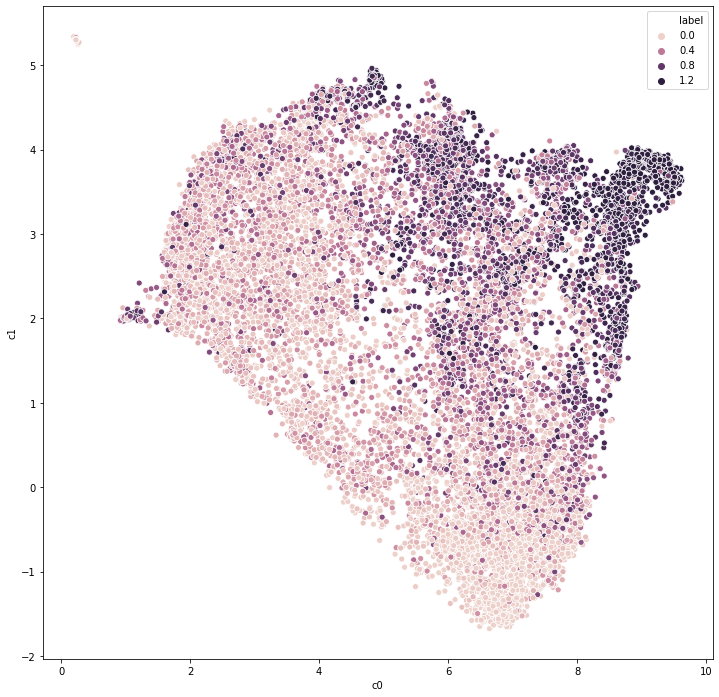

<IPython.core.display.Javascript object>

In [33]:
umap_df["label"] = df["acousticness"]
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", hue="label", data=umap_df)

In [34]:
px_df["x1"] = umap_df["c0"]
px_df["x2"] = umap_df["c1"]

<IPython.core.display.Javascript object>

In [53]:
X = umap_df[["c0", "c1"]]

clst = DBSCAN(eps=0.127, min_samples=30)
clst.fit(X)

DBSCAN(algorithm='auto', eps=0.127, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [54]:
px_df["clst_label"] = clst.labels_
px_df["clst_label"].value_counts()

-1     4742
 4     2577
 0     1774
 2      619
 3      535
 16     350
 19     296
 9      286
 6      268
 1      182
 22     150
 14     137
 13     134
 17     125
 12     107
 5       99
 7       84
 11      83
 8       81
 10      80
 20      56
 21      54
 18      54
 23      40
 15      37
 27      37
 25      30
 24      29
 26      25
Name: clst_label, dtype: int64

<IPython.core.display.Javascript object>

In [55]:
px_df["clst_label"].nunique()

29

<IPython.core.display.Javascript object>

In [56]:
# Remove DBSCAN's outlier cluster
plot_df = px_df[px_df["clst_label"] != -1].copy()

# Make cluster label a string so plotly colors like categorical rather than continuous
plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

In [57]:
x_range = [math.floor(plot_df["x1"].min()), math.ceil(plot_df["x1"].max())]
y_range = [math.floor(plot_df["x2"].min()), math.ceil(plot_df["x2"].max())]

descriptors = px_num.columns

<IPython.core.display.Javascript object>

In [58]:


@interact(
    filter_col = descriptors,
    min_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=0,continuous_update=False),
    max_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=1,continuous_update=False),
    
)
def song_plot(filter_col, min_val=0.0, max_val=1.0):
    int_plot_df = plot_df.copy()
    int_plot_df = int_plot_df[int_plot_df[filter_col].between(min_val, max_val)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


interactive(children=(Dropdown(description='filter_col', options=('popularity', 'danceability', 'energy', 'lou…

<IPython.core.display.Javascript object>

In [59]:
@interact_manual(search_genre=False, genre="search")
def song_plot(genre, search_genre):

    int_plot_df = plot_df.copy()
    if search_genre == True:
        int_plot_df = int_plot_df[int_plot_df["genres"].str.contains(genre)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols + ["clst_label"],
        range_x=x_range,
        range_y=y_range,
    )

    #     fig.update_layout(showlegend=False)
    fig.show()

interactive(children=(Text(value='search', description='genre'), Checkbox(value=False, description='search_gen…

<IPython.core.display.Javascript object>

In [42]:
clust_genre_dict = {}
clust_word_dict = {}

for cl in px_df["clst_label"].unique():
    cluster_sub_df = px_df[px_df["clst_label"] == cl]
    micro_genre_count, word_count = get_keyword_counts(cluster_sub_df)

    m_genre_series = pd.Series(micro_genre_count)
    word_series = pd.Series(word_count)

    m_genre_rep = m_genre_series / cluster_sub_df.shape[0]
    w_count_rep = word_series / cluster_sub_df.shape[0]

    clust_genre_dict["cluster_" + str(cl)] = m_genre_rep
    clust_word_dict["cluster_" + str(cl)] = w_count_rep

<IPython.core.display.Javascript object>

In [43]:
cluster_genre_df = pd.DataFrame(clust_genre_dict)
cluster_keyword_df = pd.DataFrame(clust_word_dict)

<IPython.core.display.Javascript object>

In [44]:
for col in cluster_genre_df.columns:
    top_7_g = cluster_genre_df[col].sort_values(ascending=False)[0:7]
    top_7_comp = whole_df_m_genre_rep[top_7_g.index]
    print("Micro Genre Comparison")
    display(
        pd.DataFrame(
            [top_7_g, top_7_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )
    top_12_w = cluster_keyword_df[col].sort_values(ascending=False)[0:12]
    top_12_comp = whole_df_w_count_rep[top_12_w.index]
    print("Keyword Comparison")
    display(
        pd.DataFrame(
            [top_12_w, top_12_comp], index=[col, "df"]
        ).T.style.background_gradient(axis=1)
    )

Micro Genre Comparison


,cluster_0,df
rap,0.224352,0.045903
pop,0.176437,0.104659
pop rap,0.173619,0.043531
hip hop,0.143179,0.034121
trap,0.135851,0.024176
dance pop,0.121195,0.076658
melodic rap,0.100338,0.016755


Keyword Comparison


,cluster_0,df
pop,0.988726,0.748068
rap,0.860767,0.195088
hip,0.819617,0.191646
hop,0.780158,0.177645
trap,0.304397,0.061816
r&b,0.272830,0.089205
dance,0.136415,0.120802
indie,0.120068,0.181317
dancehall,0.110485,0.032438
reggae,0.108230,0.055160


Micro Genre Comparison


,cluster_3,df
latin,0.274766,0.032974
reggaeton,0.246729,0.016296
pop,0.177570,0.104659
dance pop,0.160748,0.076658
tropical,0.155140,0.018208
latin pop,0.127103,0.022263
reggaeton flow,0.112150,0.006120


Keyword Comparison


,cluster_3,df
pop,1.282243,0.748068
latin,0.564486,0.112922
reggaeton,0.467290,0.030755
hip,0.299065,0.191646
hop,0.278505,0.177645
rap,0.211215,0.195088
tropical,0.207477,0.043761
dance,0.196262,0.120802
trap,0.173832,0.061816
reggae,0.143925,0.055160


Micro Genre Comparison


,cluster_-1,df
pop,0.118305,0.104659
dance pop,0.087938,0.076658
not listed,0.075917,0.075128
rock,0.066006,0.075281
soul,0.054407,0.036340
funk,0.050401,0.034504
quiet storm,0.040700,0.027848


Keyword Comparison


,cluster_-1,df
pop,0.785955,0.748068
rock,0.559047,0.592304
indie,0.194854,0.181317
jazz,0.189582,0.154005
soul,0.174610,0.131283
country,0.140025,0.117359
modern,0.128638,0.119654
dance,0.128427,0.120802
hip,0.128216,0.191646
folk,0.122311,0.098921


Micro Genre Comparison


,cluster_1,df
soul,0.148352,0.036340
dance pop,0.126374,0.076658
motown,0.115385,0.027618
pop,0.093407,0.104659
classic soul,0.087912,0.017520
funk,0.076923,0.034504
country,0.076923,0.018973


Keyword Comparison


,cluster_1,df
pop,0.813187,0.748068
rock,0.659341,0.592304
soul,0.494505,0.131283
country,0.296703,0.117359
classic,0.230769,0.071303
dance,0.164835,0.120802
indie,0.115385,0.181317
motown,0.115385,0.028154
new,0.109890,0.095402
modern,0.093407,0.119654


Micro Genre Comparison


,cluster_27,df
shaabi,0.297297,0.004820
arab pop,0.243243,0.007191
dabke,0.108108,0.003596
not listed,0.108108,0.075128
egyptian pop,0.108108,0.003978
mahraganat,0.108108,0.004284
coupe-decale,0.081081,0.001683


Keyword Comparison


,cluster_27,df
pop,0.864865,0.748068
arab,0.297297,0.016602
shaabi,0.297297,0.004820
egyptian,0.162162,0.005279
k-pop,0.135135,0.029990
dabke,0.108108,0.003596
listed,0.108108,0.075128
funk,0.108108,0.075740
not,0.108108,0.075128
edm,0.108108,0.034427


Micro Genre Comparison


,cluster_2,df
indie folk,0.193861,0.030220
pop,0.172859,0.104659
new americana,0.126010,0.016755
stomp and holler,0.103393,0.021115
neo mellow,0.092084,0.020656
pop rock,0.071082,0.040395
not listed,0.066236,0.075128


Keyword Comparison


,cluster_2,df
pop,1.050081,0.748068
rock,0.694669,0.592304
indie,0.599354,0.181317
folk,0.437803,0.098921
americana,0.206785,0.030679
new,0.192246,0.095402
country,0.192246,0.117359
alternative,0.185784,0.138704
singer-songwriter,0.148627,0.024711
modern,0.130856,0.119654


Micro Genre Comparison


,cluster_7,df
pop,0.154762,0.104659
dance pop,0.107143,0.076658
not listed,0.107143,0.075128
reggae,0.083333,0.011093
lovers rock,0.071429,0.008339
indie r&b,0.071429,0.015072
roots reggae,0.071429,0.008645


Keyword Comparison


,cluster_7,df
pop,0.833333,0.748068
rock,0.380952,0.592304
r&b,0.273810,0.089205
house,0.250000,0.085839
soul,0.250000,0.131283
indie,0.238095,0.181317
reggae,0.238095,0.055160
alternative,0.202381,0.138704
latin,0.190476,0.112922
dance,0.190476,0.120802


Micro Genre Comparison


,cluster_4,df
rock,0.208382,0.075281
alternative rock,0.098176,0.032438
alternative metal,0.087311,0.024252
pop rock,0.082654,0.040395
modern rock,0.077610,0.035422
dance rock,0.072565,0.024252
permanent wave,0.071401,0.026088


Keyword Comparison


,cluster_4,df
rock,1.419092,0.592304
pop,0.630966,0.748068
metal,0.429569,0.107796
alternative,0.297245,0.138704
punk,0.282111,0.082779
indie,0.211486,0.181317
country,0.178114,0.117359
new,0.171129,0.095402
wave,0.168801,0.060898
modern,0.147458,0.119654


Micro Genre Comparison


,cluster_23,df
shaabi,0.225000,0.004820
k-pop,0.150000,0.019432
pop,0.125000,0.104659
arab pop,0.100000,0.007191
dance pop,0.100000,0.076658
not listed,0.100000,0.075128
r&b,0.075000,0.031214


Keyword Comparison


,cluster_23,df
pop,0.950000,0.748068
k-pop,0.275000,0.029990
shaabi,0.225000,0.004820
edm,0.150000,0.034427
r&b,0.125000,0.089205
room,0.125000,0.017061
dance,0.125000,0.120802
arab,0.125000,0.016602
group,0.125000,0.017137
house,0.125000,0.085839


Micro Genre Comparison


,cluster_6,df
not listed,0.227612,0.075128
pop,0.141791,0.104659
dance pop,0.089552,0.076658
tropical house,0.067164,0.024329
afropop,0.067164,0.012776
edm,0.063433,0.021880
nigerian pop,0.059701,0.011705


Keyword Comparison


,cluster_6,df
pop,0.600746,0.748068
house,0.440299,0.085839
not,0.227612,0.075128
listed,0.227612,0.075128
indie,0.164179,0.181317
rock,0.138060,0.592304
dance,0.138060,0.120802
r&b,0.134328,0.089205
edm,0.119403,0.034427
soul,0.111940,0.131283


Micro Genre Comparison


,cluster_24,df
pop,0.206897,0.104659
dance pop,0.172414,0.076658
tropical house,0.137931,0.024329
pop rock,0.103448,0.040395
desi pop,0.103448,0.031138
jawaiian,0.068966,0.003290
k-pop,0.068966,0.019432


Keyword Comparison


,cluster_24,df
pop,1.517241,0.748068
rap,0.275862,0.195088
house,0.275862,0.085839
dance,0.275862,0.120802
rock,0.206897,0.592304
hip,0.172414,0.191646
indie,0.172414,0.181317
tropical,0.172414,0.043761
trap,0.172414,0.061816
hop,0.172414,0.177645


Micro Genre Comparison


,cluster_5,df
rock,0.191919,0.075281
contemporary country,0.171717,0.022263
pop rock,0.161616,0.040395
modern rock,0.131313,0.035422
country,0.111111,0.018973
country road,0.090909,0.011629
country pop,0.090909,0.008339


Keyword Comparison


,cluster_5,df
rock,1.484848,0.592304
pop,0.969697,0.748068
country,0.616162,0.117359
indie,0.303030,0.181317
alternative,0.282828,0.138704
modern,0.262626,0.119654
contemporary,0.202020,0.089817
new,0.181818,0.095402
folk,0.171717,0.098921
dance,0.151515,0.120802


Micro Genre Comparison


,cluster_8,df
not listed,0.345679,0.075128
chill out,0.209877,0.006579
lo-fi beats,0.086420,0.001530
electronica,0.061728,0.006885
japanese r&b,0.049383,0.000383
chillhop,0.049383,0.000918
hip hop,0.049383,0.034121


Keyword Comparison


,cluster_8,df
listed,0.345679,0.075128
not,0.345679,0.075128
chill,0.259259,0.012623
out,0.209877,0.006579
house,0.185185,0.085839
beats,0.172840,0.003213
hop,0.123457,0.177645
soul,0.098765,0.131283
lo-fi,0.086420,0.004667
jazz,0.086420,0.154005


Micro Genre Comparison


,cluster_26,df
pop,0.320000,0.104659
dance pop,0.280000,0.076658
house,0.240000,0.005967
tropical house,0.240000,0.024329
desi pop,0.120000,0.031138
edm,0.120000,0.021880
big room,0.120000,0.008110


Keyword Comparison


,cluster_26,df
pop,1.320000,0.748068
house,1.080000,0.085839
dance,0.520000,0.120802
hip,0.400000,0.191646
hop,0.400000,0.177645
tropical,0.240000,0.043761
uk,0.200000,0.042231
desi,0.200000,0.036952
edm,0.160000,0.034427
progressive,0.160000,0.018208


Micro Genre Comparison


,cluster_17,df
soundtrack,0.216000,0.016449
not listed,0.152000,0.075128
video game music,0.136000,0.009410
scorecore,0.128000,0.010405
background music,0.112000,0.004743
chill out,0.104000,0.006579
compositional ambient,0.104000,0.009257


Keyword Comparison


,cluster_17,df
soundtrack,0.344000,0.026930
music,0.264000,0.026012
rock,0.184000,0.592304
classical,0.168000,0.100604
ambient,0.168000,0.013235
listed,0.152000,0.075128
not,0.152000,0.075128
video,0.136000,0.009410
chill,0.136000,0.012623
game,0.136000,0.010252


Micro Genre Comparison


,cluster_9,df
filmi,0.241259,0.022875
modern bollywood,0.237762,0.026394
sufi,0.227273,0.017290
desi pop,0.223776,0.031138
classic bollywood,0.150350,0.005508
chutney,0.076923,0.003137
dance pop,0.073427,0.076658


Keyword Comparison


,cluster_9,df
pop,0.793706,0.748068
rock,0.430070,0.592304
bollywood,0.388112,0.031903
modern,0.272727,0.119654
jazz,0.241259,0.154005
filmi,0.241259,0.022875
classic,0.237762,0.071303
sufi,0.227273,0.017290
desi,0.223776,0.036952
country,0.132867,0.117359


Micro Genre Comparison


,cluster_19,df
classical,0.462838,0.026318
classical performance,0.327703,0.015378
soundtrack,0.162162,0.016449
orchestral performance,0.138514,0.005585
classical era,0.135135,0.006656
orchestra,0.131757,0.006426
post-romantic era,0.114865,0.005202


Keyword Comparison


,cluster_19,df
classical,1.445946,0.100604
performance,0.496622,0.023564
orchestra,0.415541,0.018438
era,0.371622,0.019585
soundtrack,0.273649,0.026930
german,0.165541,0.020274
early,0.165541,0.014383
british,0.155405,0.025017
modern,0.148649,0.119654
baroque,0.145270,0.014766


Micro Genre Comparison


,cluster_15,df
quiet storm,0.216216,0.027848
funk,0.189189,0.034504
dance pop,0.162162,0.076658
urban contemporary,0.135135,0.033433
soul,0.135135,0.036340
motown,0.135135,0.027618
dub,0.108108,0.004667


Keyword Comparison


,cluster_15,df
pop,0.783784,0.748068
rock,0.594595,0.592304
funk,0.405405,0.075740
dance,0.297297,0.120802
new,0.297297,0.095402
wave,0.243243,0.060898
soul,0.216216,0.131283
african,0.216216,0.013312
jazz,0.216216,0.154005
storm,0.216216,0.027848


Micro Genre Comparison


,cluster_14,df
tropical,0.255474,0.018208
salsa,0.226277,0.004590
latin,0.197080,0.032974
modern salsa,0.116788,0.001913
latin jazz,0.116788,0.007268
salsa peruana,0.109489,0.001377
salsa colombiana,0.080292,0.001148


Keyword Comparison


,cluster_14,df
salsa,0.664234,0.012088
pop,0.598540,0.748068
latin,0.452555,0.112922
jazz,0.313869,0.154005
tropical,0.255474,0.043761
rock,0.226277,0.592304
modern,0.197080,0.119654
soul,0.124088,0.131283
peruana,0.109489,0.001377
colombiana,0.102190,0.001530


Micro Genre Comparison


,cluster_13,df
funk,0.283582,0.034504
soul,0.216418,0.036340
motown,0.171642,0.027618
quiet storm,0.141791,0.027848
disco,0.097015,0.014842
urban contemporary,0.097015,0.033433
classic soul,0.097015,0.017520


Keyword Comparison


,cluster_13,df
rock,0.917910,0.592304
funk,0.597015,0.075740
soul,0.537313,0.131283
pop,0.529851,0.748068
jazz,0.253731,0.154005
south,0.216418,0.016678
african,0.216418,0.013312
new,0.194030,0.095402
indie,0.194030,0.181317
motown,0.171642,0.028154


Micro Genre Comparison


,cluster_10,df
country,0.112500,0.018973
rock-and-roll,0.112500,0.009640
desi pop,0.112500,0.031138
rockabilly,0.087500,0.007651
filmi,0.087500,0.022875
modern bollywood,0.087500,0.026394
soul,0.087500,0.036340


Keyword Comparison


,cluster_10,df
pop,0.850000,0.748068
rock,0.575000,0.592304
country,0.375000,0.117359
soul,0.237500,0.131283
classic,0.212500,0.071303
latin,0.187500,0.112922
folk,0.175000,0.098921
bollywood,0.125000,0.031903
modern,0.125000,0.119654
rock-and-roll,0.112500,0.009869


Micro Genre Comparison


,cluster_11,df
mahraganat,0.409639,0.004284
shaabi,0.277108,0.004820
egyptian pop,0.192771,0.003978
not listed,0.144578,0.075128
pop,0.120482,0.104659
dance pop,0.108434,0.076658
pop rap,0.060241,0.043531


Keyword Comparison


,cluster_11,df
pop,0.795181,0.748068
mahraganat,0.409639,0.004284
shaabi,0.277108,0.004820
hip,0.216867,0.191646
hop,0.204819,0.177645
egyptian,0.192771,0.005279
rap,0.168675,0.195088
not,0.144578,0.075128
listed,0.144578,0.075128
dance,0.132530,0.120802


Micro Genre Comparison


,cluster_12,df
"""children's story""",0.345794,0.002831
nursery,0.186916,0.001683
not listed,0.149533,0.075128
"""children's music""",0.112150,0.004055
urban contemporary,0.056075,0.033433
neo soul,0.056075,0.017749
pop,0.056075,0.104659


Keyword Comparison


,cluster_12,df
"""children's",0.476636,0.008722
"story""",0.345794,0.002831
nursery,0.186916,0.001683
not,0.149533,0.075128
listed,0.149533,0.075128
"music""",0.130841,0.005355
soul,0.130841,0.131283
pop,0.130841,0.748068
neo,0.102804,0.039706
contemporary,0.065421,0.089817


Micro Genre Comparison


,cluster_22,df
jazz,0.600000,0.014383
cool jazz,0.586667,0.014077
contemporary post-bop,0.580000,0.014077
bebop,0.573333,0.013465
hard bop,0.480000,0.011170
soul jazz,0.413333,0.011017
jazz fusion,0.380000,0.010634


Keyword Comparison


,cluster_22,df
jazz,4.386667,0.154005
contemporary,0.840000,0.089817
cool,0.586667,0.014077
post-bop,0.580000,0.014077
bebop,0.573333,0.013465
bop,0.480000,0.011170
hard,0.480000,0.027542
soul,0.420000,0.131283
fusion,0.406667,0.023487
vocal,0.293333,0.010940


Micro Genre Comparison


,cluster_18,df
pop,0.185185,0.104659
dance pop,0.129630,0.076658
indie folk,0.111111,0.030220
mellow gold,0.092593,0.027159
quiet storm,0.092593,0.027848
soul,0.092593,0.036340
soft rock,0.092593,0.025553


Keyword Comparison


,cluster_18,df
pop,1.037037,0.748068
rock,0.500000,0.592304
indie,0.351852,0.181317
folk,0.259259,0.098921
soul,0.240741,0.131283
jazz,0.185185,0.154005
mellow,0.166667,0.047816
americana,0.129630,0.030679
dance,0.129630,0.120802
singer-songwriter,0.129630,0.024711


Micro Genre Comparison


,cluster_16,df
classical,0.311429,0.026318
classical piano,0.237143,0.008951
not listed,0.174286,0.075128
background piano,0.140000,0.003902
classical performance,0.134286,0.015378
calming instrumental,0.097143,0.004896
early music,0.082857,0.005126


Keyword Comparison


,cluster_16,df
classical,1.357143,0.100604
piano,0.845714,0.042154
era,0.254286,0.019585
early,0.202857,0.014383
performance,0.188571,0.023564
not,0.174286,0.075128
listed,0.174286,0.075128
background,0.171429,0.008645
baroque,0.160000,0.014766
jazz,0.154286,0.154005


Micro Genre Comparison


,cluster_25,df
indie folk,0.433333,0.030220
stomp and holler,0.200000,0.021115
indie pop,0.166667,0.023564
indie anthem-folk,0.133333,0.005891
neo mellow,0.133333,0.020656
indie rock,0.100000,0.022263
freak folk,0.100000,0.008492


Keyword Comparison


,cluster_25,df
indie,1.333333,0.181317
pop,1.033333,0.748068
rock,0.633333,0.592304
folk,0.600000,0.098921
country,0.600000,0.117359
americana,0.266667,0.030679
stomp,0.200000,0.022340
and,0.200000,0.024252
singer-songwriter,0.200000,0.024711
holler,0.200000,0.021115


Micro Genre Comparison


,cluster_20,df
chill guitar,0.410714,0.001989
calming instrumental,0.392857,0.004896
not listed,0.250000,0.075128
focus,0.089286,0.003596
acoustic chill,0.035714,0.000153
swedish jazz,0.035714,0.001071
background music,0.035714,0.004743


Keyword Comparison


,cluster_20,df
chill,0.446429,0.012623
guitar,0.410714,0.004896
instrumental,0.410714,0.011629
calming,0.392857,0.004896
listed,0.250000,0.075128
not,0.250000,0.075128
jazz,0.142857,0.154005
rock,0.125000,0.592304
country,0.089286,0.117359
focus,0.089286,0.003902


Micro Genre Comparison


,cluster_21,df
asmr,1.000000,0.004437
"""australian children's music""",nan,0.000306
"""black 'n' roll""",nan,0.000077
"""canadian children's music""",nan,0.000306
"""children's folk""",nan,0.001836
"""children's music""",nan,0.004055
"""children's story""",nan,0.002831


Keyword Comparison


,cluster_21,df
asmr,1.000000,0.004437
"""australian",nan,0.000306
"""black",nan,0.000077
"""canadian",nan,0.000306
"""children's",nan,0.008722
"""death",nan,0.000077
"""preschool",nan,0.000153
"""punk",nan,0.000459
"""women's",nan,0.000612
'n',nan,0.000612


<IPython.core.display.Javascript object>

In [45]:
from hdbscan import HDBSCAN

<IPython.core.display.Javascript object>

In [46]:
X

,c0,c1
0,2.032892,2.624519
1,2.656412,4.148885
2,2.404122,2.572405
3,3.527201,2.264394
4,2.351059,1.867088
...,...,...
13066,6.968793,1.931878
13067,3.188431,1.799471
13068,2.714284,1.872319
13069,1.987294,3.572662


<IPython.core.display.Javascript object>

In [47]:
h_clst = HDBSCAN(
    min_cluster_size=25,
    min_samples=60,
    metric="euclidean",
    cluster_selection_epsilon=0.06,
)
h_clst.fit(np.array(X))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.06,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=25, min_samples=60, p=None,
        prediction_data=False)

<IPython.core.display.Javascript object>

In [48]:
px_df["clst_label"] = h_clst.labels_
px_df["clst_label"].value_counts()

-1     4328
 1     3844
 11    2309
 6      747
 4      689
 9      478
 7      132
 5      117
 0      110
 2      102
 3       98
 8       79
 10      38
Name: clst_label, dtype: int64

<IPython.core.display.Javascript object>

In [49]:
px_df["clst_label"].nunique()

13

<IPython.core.display.Javascript object>

In [50]:
# Remove DBSCAN's outlier cluster
plot_df = px_df[px_df["clst_label"] != -1].copy()

# Make cluster label a string so plotly colors like categorical rather than continuous
plot_df["clst_label"] = "'" + plot_df["clst_label"].astype(str) + "'"

<IPython.core.display.Javascript object>

In [51]:
x_range = [math.floor(plot_df["x1"].min()), math.ceil(plot_df["x1"].max())]
y_range = [math.floor(plot_df["x2"].min()), math.ceil(plot_df["x2"].max())]

descriptors = px_num.columns

<IPython.core.display.Javascript object>

In [52]:


@interact(
    filter_col = descriptors,
    min_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=0,continuous_update=False),
    max_val=FloatSlider(min=0.0,max=1.0, step=0.01,value=1,continuous_update=False),
    
)
def song_plot(filter_col, min_val=0.0, max_val=1.0):
    int_plot_df = plot_df.copy()
    int_plot_df = int_plot_df[int_plot_df[filter_col].between(min_val, max_val)]
    fig = px.scatter(
        data_frame=int_plot_df,
        x="x1",
        y="x2",
        color="clst_label",
        hover_data=desc_cols+['clst_label'],
        range_x = x_range,
        range_y=y_range
    )

#     fig.update_layout(showlegend=False)
    fig.show()


interactive(children=(Dropdown(description='filter_col', options=('popularity', 'danceability', 'energy', 'lou…

<IPython.core.display.Javascript object>